In [ ]:
from audioop import mul
from IPython import get_ipython


In [6]:
#import skimage.restoration
#import skimage.filters
#import skimage.morphology
import os
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow.python.ops.gen_parsing_ops import decode_raw
from tensorflow_addons.image import filters
import numpy as np
import csv
import random
import time
TF_ENABLE_ONEDNN_OPTS=1
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0],True)

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False
#Select model

clipByTop = 1
clipByButtom = -1

pretrained_model = tf.keras.applications.MobileNetV3Large(include_top=True,weights='imagenet',include_preprocessing=False)
decode_predictions = tf.keras.applications.mobilenet_v3.decode_predictions

#Using preprocess_input of v2 to convert image values from [0,255] to [-1,1]. preprocess_input of v3 no longer does it.
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


pretrained_model.trainable = False
input_shape = pretrained_model.input_shape[1]

# Helper function to extract labels from probability vector

loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_gradient(input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = pretrained_model(input_image)
        loss = loss_object(input_label, prediction)
        # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_image)
    return gradient

#Fast Gradient Sign Method
def adversarial_pattern_FGSM(gradient):
    return tf.sign(gradient) #invgrad/np.max(np.abs(invgrad))

#Precise Gradient Method
def adversarial_pattern_PGM(gradient):
    return gradient/tf.reduce_max(tf.abs(gradient))

#Fast Gradient Non sign Method
def adversarial_pattern_FGNM(gradient):
    return(tf.norm(tf.sign(gradient))/tf.norm(gradient))*gradient

def display_images(image):
    probs = pretrained_model.predict(image)
    _, label, confidence = decode_predictions(probs, top=1)[0][0]
    plt.figure()
    plt.imshow(image[0]*0.5+0.5)
    plt.title('{} \n {} : {:.2f}% Confidence'.format(np.argmax(probs), label, confidence*100))
    plt.show()

# Iterative noise generation
def iterative_noise_generation(image, d_class, eps=0.001, spread=0, confidence=0.7,adversarial_pattern=adversarial_pattern_FGSM):
    perturbations = adversarial_pattern(create_gradient(image,d_class))
    #spread component
    perturbations_spread = eps*perturbations + spread*(tf.sign(perturbations) - perturbations)
    iterCount = 1
    adv_x = image - perturbations_spread
    adv_x = tf.clip_by_value(adv_x, clipByButtom, clipByTop)
    adv_probs = pretrained_model.predict(adv_x)
    # Keep looping until we get the aversarial label
    while (np.argmax(adv_probs) != np.argmax(d_class) or np.max(adv_probs) < confidence) and iterCount < 1000:
        perturbations += adversarial_pattern(create_gradient(image,d_class))
        #spread component
        perturbations_spread = eps*perturbations + spread*(tf.sign(perturbations) - perturbations)
        adv_x = image - perturbations_spread
        adv_x = tf.clip_by_value(adv_x, clipByButtom, clipByTop)
        adv_probs = pretrained_model.predict(adv_x)
        #if iterCount%10 == 0:
        #    _, label, conf = decode_predictions(adv_probs, top=1)[0][0]
        #    print('Attempt: {}, image label: {}, confidence: {}, Index: {}'.format(iterCount, label, conf, np.argmax(adv_probs)))
        print('Iteration: {}'.format(iterCount), end='\r')
        iterCount += 1
    return perturbations_spread, iterCount

#Adversarial Example generation algorithm
def AE_generation(image, d_class, eps=0.005, increment=0.005,adversarial_pattern=adversarial_pattern_FGSM):
    image_probs = pretrained_model.predict(image)
    perturbations, iterCount = iterative_noise_generation(image, d_class, eps,adversarial_pattern=adversarial_pattern)
    adv_x = image - perturbations
    adv_x = tf.clip_by_value(adv_x, clipByButtom, clipByTop)
    # adv_probs = pretrained_model.predict(adv_x)
    filtered_x = filters.median_filter2d(adv_x, (5, 5))
    filtered_probs = pretrained_model.predict(filtered_x)
    spread = 0 #spread multiplier
    while np.argmax(filtered_probs) == np.argmax(image_probs) and iterCount < 1000:
        '''print('eps: {},iterCount: {}, Filtered image label: {} Index: {}'.format(
            eps, iterCount, decode_predictions(filtered_probs, top=1)[0][0][1], np.argmax(filtered_probs)))'''
        eps += increment
        if adversarial_pattern == adversarial_pattern_PGM:
            spread += increment #spread multiplier
        perturbations, j = iterative_noise_generation(image, d_class, eps, spread,adversarial_pattern=adversarial_pattern)
        iterCount += j
        adv_x = image - perturbations
        adv_x = tf.clip_by_value(adv_x, clipByButtom, clipByTop)
        # adv_probs = pretrained_model.predict(adv_x)
        filtered_x = filters.median_filter2d(adv_x, (5, 5))
        filtered_probs = pretrained_model.predict(filtered_x)
    return perturbations, eps, iterCount

def preprocess(image):
    image = tf.image.resize(image, (224, 224))
    image = preprocess_input(image)
    image = image[None, ...]
    return image

def generate_AE_demo(image,image_probs,label,confidence):
    f ,axarr = plt.subplots(2,2,figsize=(18,18))
    axarr[0][0].imshow(image[0]*0.5+0.5)
    axarr[0][0].title.set_text('Original image: {} {} : {:.2f}% Confidence'.format(np.argmax(image_probs), label, confidence*100))
    
    print('Generating adversarial example with FGSM')
    delta, eps, iterCount = AE_generation(image,d_class,eps=0.005,increment=0.005,adversarial_pattern=adversarial_pattern_FGSM)
    adv_x = image - delta
    adv_x = tf.clip_by_value(adv_x, clipByButtom, clipByTop)
    adv_probs = pretrained_model.predict(adv_x)
    _, adv_label, adv_confidence = decode_predictions(adv_probs, top=1)[0][0]
    axarr[0][1].imshow(adv_x[0]*0.5+0.5)
    axarr[0][1].title.set_text('FGSM: {} {} : {:.2f}% Confidence\niterations: {}, noise: {}'.format(
        np.argmax(adv_probs), adv_label, adv_confidence*100,iterCount, tf.linalg.norm(image[0]-adv_x[0]).numpy()))

    print('Generating adversarial example with FGNM')
    delta, eps, iterCount = AE_generation(image,d_class,eps=0.005,increment=0.005,adversarial_pattern=adversarial_pattern_FGNM)
    adv_x = image - delta
    adv_x = tf.clip_by_value(adv_x, clipByButtom, clipByTop)
    adv_probs = pretrained_model.predict(adv_x)
    _, adv_label, adv_confidence = decode_predictions(adv_probs, top=1)[0][0]
    axarr[1][0].imshow(adv_x[0]*0.5+0.5)
    axarr[1][0].title.set_text('FGNM: {} {} : {:.2f}% Confidence\niterations: {} noise: {}'.format(
        np.argmax(adv_probs), adv_label, adv_confidence*100,iterCount, tf.linalg.norm(image[0]-adv_x[0]).numpy()))

    print('Generating adversarial example with PGM')
    delta, eps, iterCount = AE_generation(image,d_class,eps=0.1,increment=0.01,adversarial_pattern=adversarial_pattern_PGM)
    adv_x = image - delta
    adv_x = tf.clip_by_value(adv_x, clipByButtom, clipByTop)
    adv_probs = pretrained_model.predict(adv_x)
    _, adv_label, adv_confidence = decode_predictions(adv_probs, top=1)[0][0]
    axarr[1][1].imshow(adv_x[0]*0.5+0.5)
    axarr[1][1].title.set_text('PGM: {} {} : {:.2f}% Confidence\niterations: {} noise: {}'.format(
        np.argmax(adv_probs), adv_label, adv_confidence*100,iterCount, tf.linalg.norm(image[0]-adv_x[0]).numpy()))

    plt.show()

In [7]:
image_path = tf.keras.utils.get_file('Lion_waiting_in_Namibia.jpg','https://upload.wikimedia.org/wikipedia/commons/7/73/Lion_waiting_in_Namibia.jpg')

image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

image = preprocess(image)

Image: 291 lion, confidence: 0.9915913343429565
Random class target: 129 spoonbill
Generating adversarial example with FGSM
Generating adversarial example with FGNM
Generating adversarial example with PGM


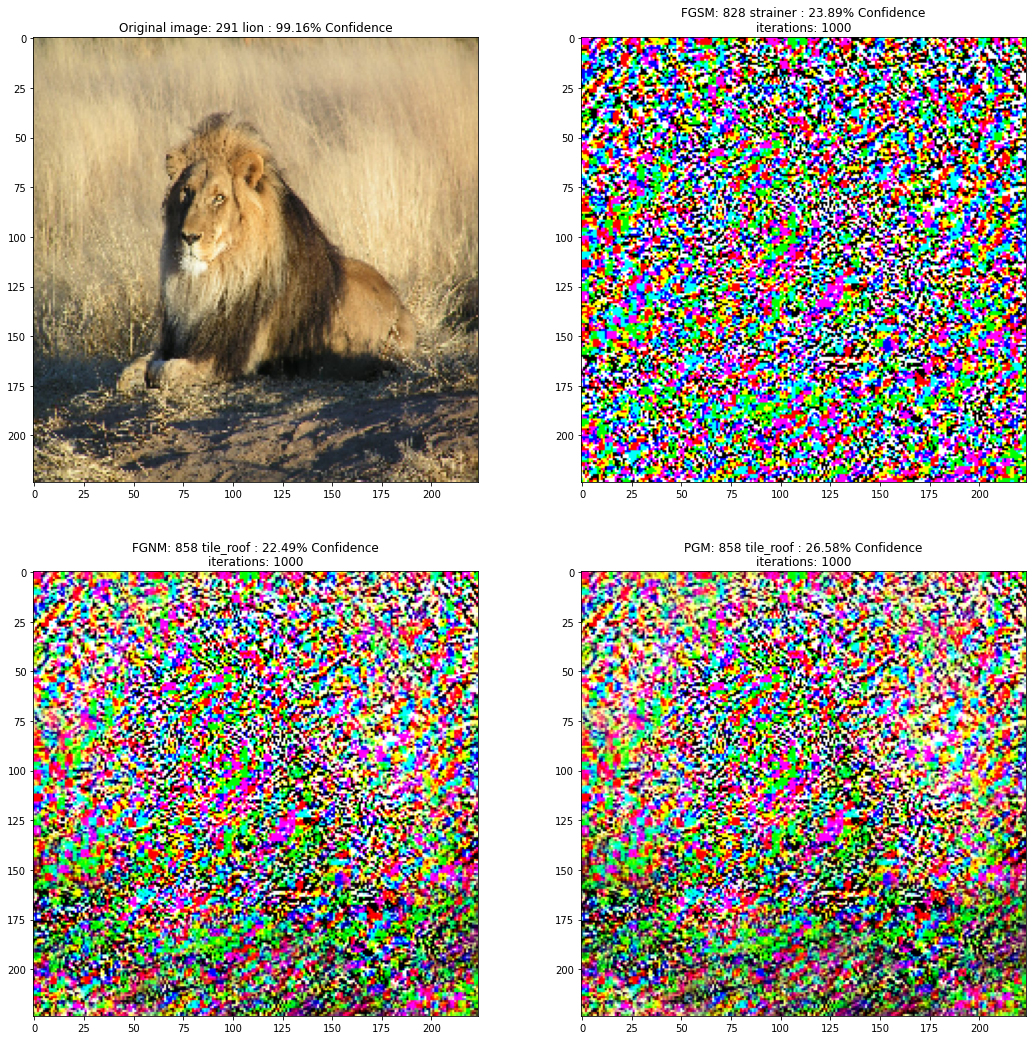

In [3]:
#Random target
image_probs = pretrained_model.predict(image)
_, label, confidence = decode_predictions(image_probs, top=1)[0][0]
dNumber = random.randrange(0,1000)
while np.argmax(image_probs) == dNumber:
    dNumber = random.randrange(0,1000)
d_class = tf.one_hot(dNumber, 1000)
d_class = tf.reshape(d_class, (1, 1000))
print('Image: {} {}, confidence: {}'.format(np.argmax(image_probs),label,confidence))
print('Random class target: {} {}'.format(dNumber,decode_predictions(d_class.numpy(), top=1)[0][0][1]))

generate_AE_demo(image,image_probs,label,confidence)

Image: 291 lion, confidence: 0.9915913343429565
Class based target: 276 hyena
Generating adversarial example with FGSM
Generating adversarial example with FGNM
Generating adversarial example with PGM


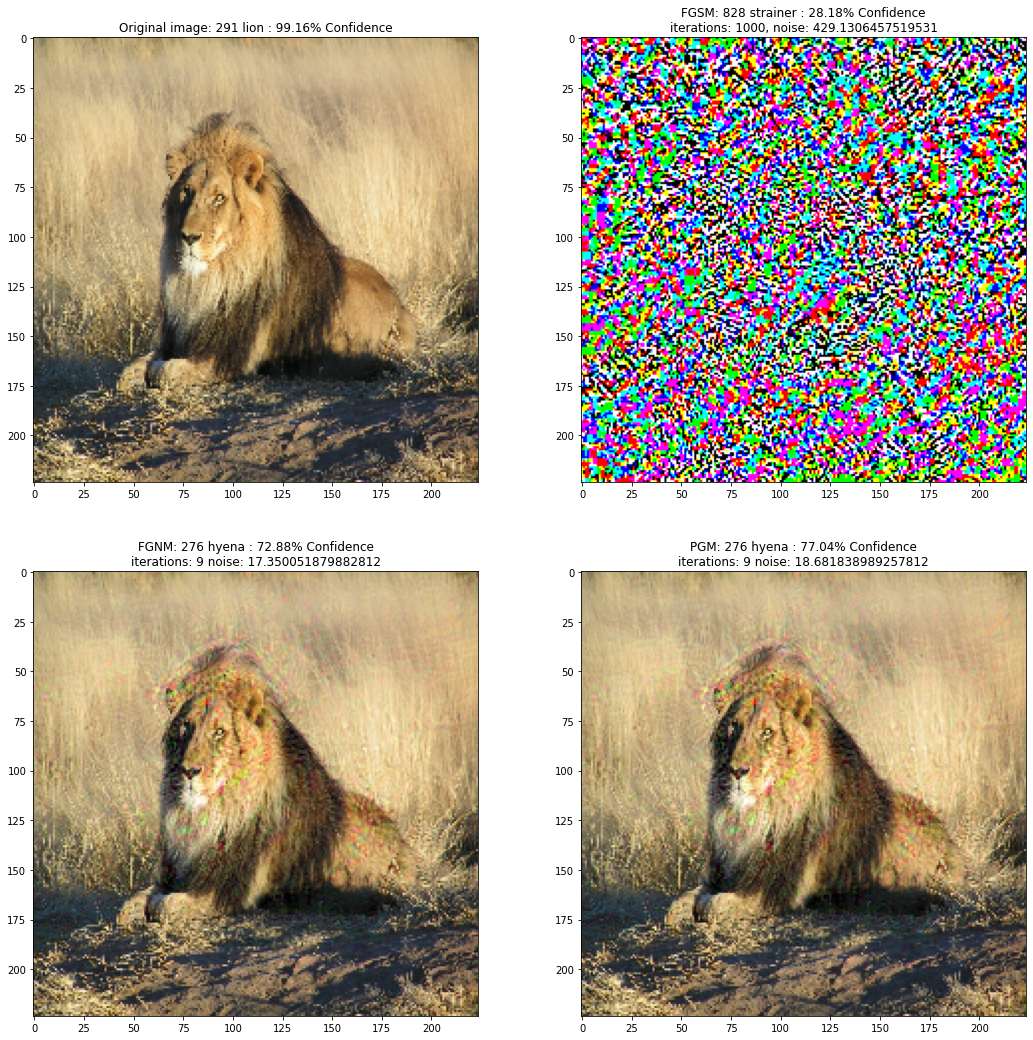

In [9]:
#Class Based target
image_probs = pretrained_model.predict(image)
_, label, confidence = decode_predictions(image_probs, top=1)[0][0]
dNumber = np.argsort(image_probs[0])[-10]
d_class = tf.one_hot(dNumber, 1000)
d_class = tf.reshape(d_class, (1, 1000))
print('Image: {} {}, confidence: {}'.format(np.argmax(image_probs),label,confidence))
print('Class based target: {} {}'.format(dNumber,decode_predictions(d_class.numpy(), top=1)[0][0][1]))

generate_AE_demo(image,image_probs,label,confidence)

Image: 291 lion, confidence: 0.9915913343429565
Relation network target: 348 ram
Generating adversarial example with FGSM
Generating adversarial example with FGNM
Generating adversarial example with PGM


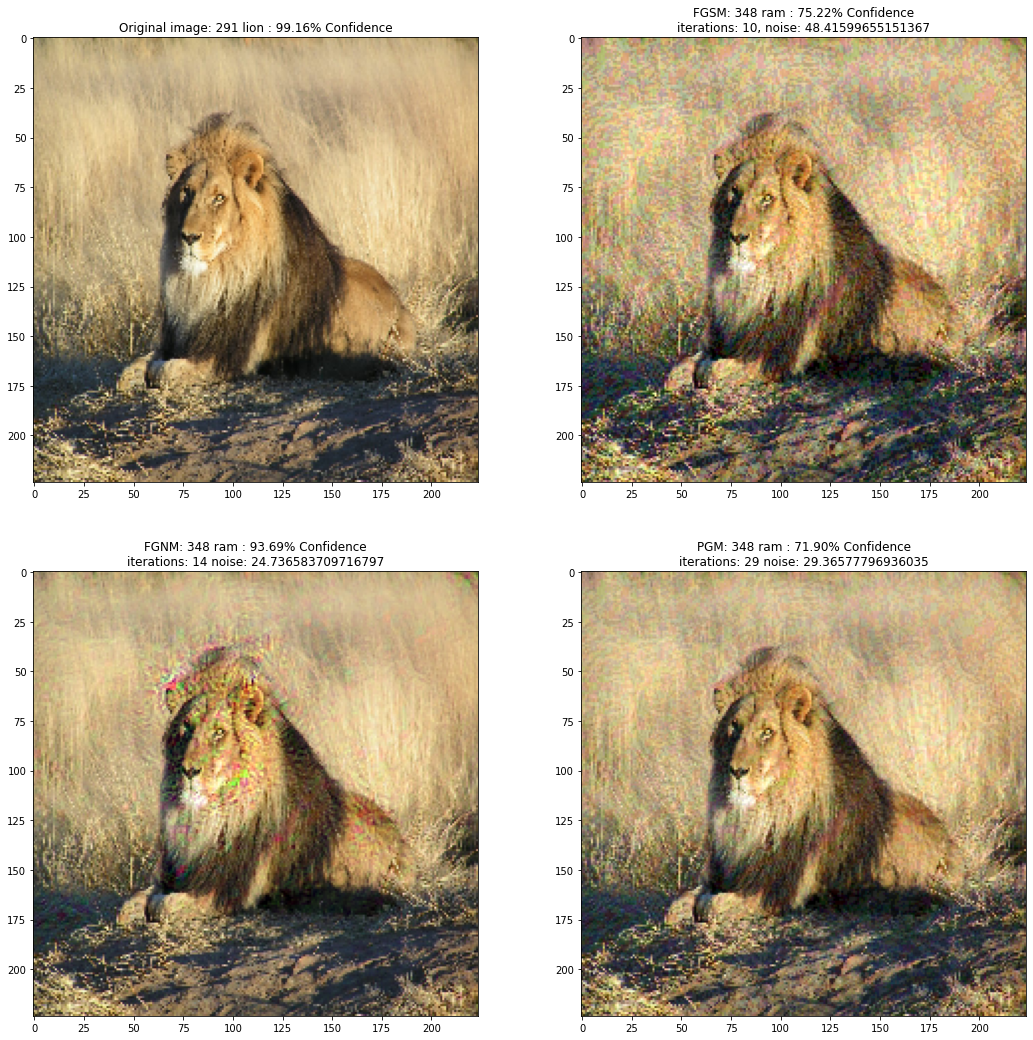

In [8]:
#Relation network
image_probs = pretrained_model.predict(image)
_, label, confidence = decode_predictions(image_probs, top=1)[0][0]
with open('RelNet.csv',mode='r') as resf:
    reader = csv.DictReader(resf)
    dslist = list(reader)
dNumber = int(dslist[np.argmax(image_probs)]['20'])

d_class = tf.one_hot(dNumber, 1000)
d_class = tf.reshape(d_class, (1, 1000))
print('Image: {} {}, confidence: {}'.format(np.argmax(image_probs),label,confidence))
print('Relation network target: {} {}'.format(dNumber,decode_predictions(d_class.numpy(), top=1)[0][0][1]))

generate_AE_demo(image,image_probs,label,confidence)